In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("ag_news", split="train")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

## Examine the dataset

In [3]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
Small Businesses May Get Break on Phones Regional phone companies still would have to share their networks with companies competing for local business customers but eventually wouldn #39;t have to do the same for rivals 

Sample 2
AT T Wireless Moves to Sell Canada Asset AT T Wireless reached an agreement with Rogers Communications to help sell AT T Wireless's 34 percent stake in Rogers Wireless Communications Inc.

Sample 3
New front: Recording of digital broadcasts Technologies that let people record satellite and Internet radio broadcasts digitally are opening a new front in the recording industry #39;s war on music piracy.

Sample 4
Breakthrough promises hotter, tougher, faster chips Developments in silicon carbide wafers may lead to a new world of fast, robust electronics.

Sample 5
Honeywell to buy Novar in \$1.7b deal New Jersey-based Honeywell International Inc. , the aerospace and high-tech manufacturer, has agreed to buy the British industrial holding company Novar P

In [4]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}

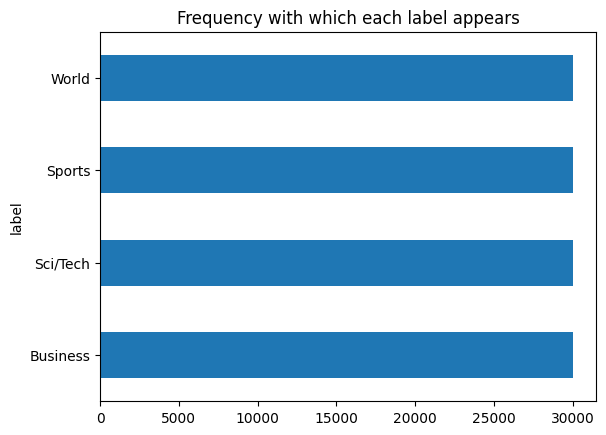

In [5]:
(
    dataset.select_columns('label')
        .to_pandas()
        .astype(str)['label']
        .map(id2label)
        .value_counts()
        .plot(kind="barh", title="Frequency with which each label appears")
);

In [6]:
def get_length_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_length_of_text)
dataset[:10]['length_of_text']

[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

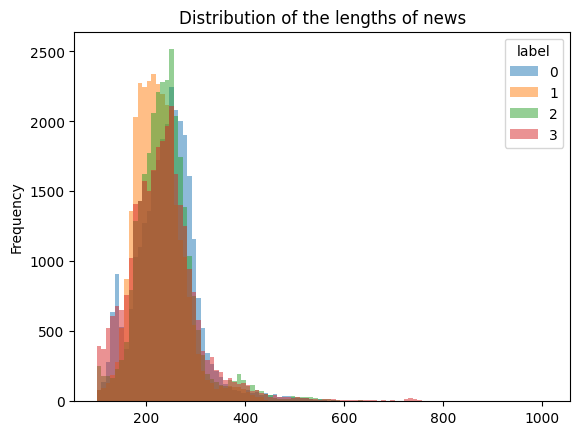

In [7]:
(
    dataset.select_columns(["label", "length_of_text"])
        .to_pandas()
        .pivot(columns='label', values='length_of_text')
        .plot.hist(bins=100, alpha=0.5, title="Distribution of the lengths of news")
);

## Tokenize and embed data using GPT-2

In [8]:
from transformers import AutoModel, AutoTokenizer
import torch

In [9]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

mps_device

device(type='mps')

In [10]:
%%time
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModel.from_pretrained('gpt2').to(mps_device)

CPU times: user 773 ms, sys: 932 ms, total: 1.71 s
Wall time: 924 ms


In [11]:
tokenizer.eos_token

'<|endoftext|>'

In [12]:
tokenizer.pad_token

In [13]:
tokenizer.pad_token = tokenizer.eos_token

In [14]:
text = "What does a cow use to do math? A cow-culator."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt").to(mps_device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,    13]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}

In [15]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 '.']

In [16]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator.'

In [17]:
tokenizer.vocab_size

50257

In [18]:
%%time
with torch.no_grad():
    embs = model(**inputs) # passing in input_ids=... and attention_mask=...

embs.last_hidden_state.size(), embs[0]

CPU times: user 460 ms, sys: 134 ms, total: 595 ms
Wall time: 563 ms


(torch.Size([1, 15, 768]),
 tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
          [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
          [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
          ...,
          [ 0.0686,  0.2000,  0.2881,  ...,  0.2151, -0.5111, -0.2907],
          [-0.0662,  0.3934, -0.8001,  ...,  0.2597, -0.1465, -0.1695],
          [-0.1900, -0.2704, -0.3135,  ...,  0.3318, -0.4120, -0.0153]]],
        device='mps:0'))

In [19]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [20]:
embedding = mean_pooling(embs, inputs["attention_mask"])
embedding.shape, embedding[0, :10]

(torch.Size([1, 768]),
 tensor([-0.2175, -0.0280, -0.4393, -0.0739, -0.1338,  0.3550,  3.4335,  0.1762,
         -0.1412,  0.1184], device='mps:0'))

In [21]:
def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    ).to(mps_device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [22]:
%%time
small_set = (
    dataset.shuffle(42)
        .select(range(1000))
        .map(embed_text, batched=True, batch_size=128)
)

CPU times: user 1.75 s, sys: 2.24 s, total: 3.99 s
Wall time: 10.9 s


In [23]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding'],
    num_rows: 1000
})

In [24]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx'],
    num_rows: 1000
})

In [25]:
small_set['idx'][-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [26]:
%%time
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

CPU times: user 11.8 ms, sys: 1.7 ms, total: 13.5 ms
Wall time: 15.1 ms


Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names'],
    num_rows: 1000
})

In [27]:
dim_size = len(small_set[0]["embedding"])
dim_size

768

## Semantic search with Qdrant

In [38]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

In [39]:
client = QdrantClient(host="localhost", port=6333)
client

In [35]:
my_collection = "article_embeddings"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

True

In [50]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

[{'label_names': 'World',
  'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
 {'label_names': 'Sports',
  'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
 {'label_names': 'World',
  'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'}]

In [37]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [38]:
client.scroll(
    collection_name=my_collection,
    limit=10,
    with_payload=False,
    with_vectors=True
)

([Record(id=0, payload=None, vector=[-0.00063278887, 0.0016740571, -0.00077123276, -5.5863835e-05, 0.0002760857, -0.0014787039, 0.0031998705, 0.0004947575, 0.00042771077, -3.868898e-05, 0.0011207716, 0.00054051465, 0.0018023439, -9.036282e-05, -0.00017948648, -0.0003924244, 0.0010584426, 0.0008693831, 0.0009496322, -0.0037449806, -0.00058958965, 0.0003965647, -0.0016344849, 0.00034770815, 0.0024551502, 0.00065716164, -5.214897e-05, -0.000126529, -0.0016560854, -0.0011843349, -0.00027212597, -0.0008318421, -0.0001785965, -0.00058161025, 0.0011239434, 0.00055251137, 0.31828925, 0.0019404026, -0.0007352335, -0.0014623576, -0.002729683, 0.0009773945, 0.0008350809, 0.00021122093, -0.0012530747, -0.0006617835, 0.0014656093, 0.002014575, -0.0009357213, 0.0027895407, -0.00068519823, -0.00032279943, 0.001135887, -0.0016646415, 0.00064953696, 0.007292676, -0.0017130077, -0.000812207, 0.00015627638, -0.0008385818, -0.0011207632, 0.00018713585, 7.231483e-05, -1.8422723e-05, -0.0052158, -0.00080973

In [39]:
which = 125
query1 = small_set[which]["embedding"]
small_set[which]['text'], query1[:7]

('Teen Newsbreak - Getting out the vote A nonpartisan national group is trying to get a record number of voters to the polls this year. By MARK ZALOUDEK. Scientists are unlocking some of the mysteries of the universe as planetary exploration forges ahead on several fronts.',
 [-0.11196517199277878,
  0.022995082661509514,
  -0.007425087038427591,
  -0.02769952081143856,
  -0.12528225779533386,
  -0.3555556833744049,
  5.064748287200928])

In [40]:
client.search(
    collection_name=my_collection,
    query_vector=query1,
    limit=3
)

[ScoredPoint(id=125, version=0, score=0.9999998, payload={'label_names': 'Sci/Tech', 'text': 'Teen Newsbreak - Getting out the vote A nonpartisan national group is trying to get a record number of voters to the polls this year. By MARK ZALOUDEK. Scientists are unlocking some of the mysteries of the universe as planetary exploration forges ahead on several fronts.'}, vector=None, shard_key=None),
 ScoredPoint(id=434, version=0, score=0.99948144, payload={'label_names': 'Sci/Tech', 'text': "Science, Politics Collide in Election Year (AP) AP - With more than 4,000 scientists, including 48 Nobel Prize winners, having signed a statement opposing the Bush administration's use of scientific advice, this election year is seeing a new development in the uneasy relationship between science and politics."}, vector=None, shard_key=None),
 ScoredPoint(id=664, version=0, score=0.99936706, payload={'label_names': 'World', 'text': 'Kerry: Bush Policies Full of Bad Choices DETROIT - Democratic presiden

In [41]:
query2 = {"text": dataset[choice(range(len(dataset)))]["text"]}
query2

{'text': 'Petit may provide Arsenal with stop-gap solution - Wenger Arsenal may consider signing French midfielder Emmanuel Petit as a stop-gap solution to their midfield injury problems, manager Arsene Wenger says.'}

In [42]:
query2 = embed_text(query2)["embedding"][0, :]
query2.shape, query2[:20]

((768,),
 array([-0.17449205, -0.32711458,  0.34321487, -0.27964067, -0.05449936,
        -0.22689652,  2.3822277 ,  0.56707555,  0.20280796,  0.11207088,
         0.27503362,  0.07379329,  0.02642385,  0.2474757 ,  0.12957498,
        -0.06495559, -0.18510373, -0.18977563,  0.0824142 , -0.4571775 ],
       dtype=float32))

In [43]:
query2.tolist()[:20]

[-0.17449204623699188,
 -0.3271145820617676,
 0.34321486949920654,
 -0.27964067459106445,
 -0.05449935793876648,
 -0.2268965244293213,
 2.382227659225464,
 0.5670755505561829,
 0.2028079628944397,
 0.11207088083028793,
 0.2750336229801178,
 0.07379329204559326,
 0.026423845440149307,
 0.24747569859027863,
 0.1295749843120575,
 -0.06495559215545654,
 -0.18510372936725616,
 -0.18977563083171844,
 0.08241420239210129,
 -0.4571774899959564]

In [44]:
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    limit=3
)

[ScoredPoint(id=157, version=0, score=0.9991501, payload={'label_names': 'Sports', 'text': "Gloucester slows down Winthrop A sense of history is valuable, even in a football game. Gloucester has watched Winthrop's Anthony Fucillo walk all over the Northeastern Conference this season. Through eight games, Fucillo had thrown 11 touchdown passes and scored 87 points."}, vector=None, shard_key=None),
 ScoredPoint(id=235, version=0, score=0.99911994, payload={'label_names': 'Sports', 'text': 'Blackburn step up chase for Hughes LONDON, England -- Blackburn Rovers have made an official approach to talk to Welsh national manager Mark Hughes about the vacant job at Ewood Park.'}, vector=None, shard_key=None),
 ScoredPoint(id=685, version=0, score=0.99910384, payload={'label_names': 'Sports', 'text': 'Guillen would like to return to Angles Anaheim Angels: Outfielder Jose Guillen says he still feels emotional pain from being suspended the last eight games of the regular season and being dropped f

In [45]:
business = models.Filter(
    must=[models.FieldCondition(key="label_names", match=models.MatchValue(value="Business"))]
)

In [46]:
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    query_filter=business,
    limit=3
)

[ScoredPoint(id=515, version=0, score=0.99888265, payload={'label_names': 'Business', 'text': 'Fines Against Yukos Stand A Russian court has ruled that embattled oil firm Yukos must pay nearly all the fines and penalties connected to its 2001 tax bill.'}, vector=None, shard_key=None),
 ScoredPoint(id=513, version=0, score=0.99881625, payload={'label_names': 'Business', 'text': 'EU to trim 2005 growth forecast BRUSSELS: The European Commission will revise downwards its 2005 economic growth forecast because of soaring oil prices, Economic and Monetary Affairs Commissioner Joaquin Almunia said on Wednesday.'}, vector=None, shard_key=None),
 ScoredPoint(id=923, version=0, score=0.99876463, payload={'label_names': 'Business', 'text': 'United Given New Deadline to Devise Plan A federal bankruptcy court judge on Friday gave United Airlines another 30 days to come up with a restructuring plan, but he warned the airline and its warring unions '}, vector=None, shard_key=None)]

## Recommendations API

In [32]:
from sentence_transformers import SentenceTransformer, util

In [42]:
from transformers import AutoModel
from numpy.linalg import norm

cos_sim = lambda a,b: (a @ b.T) / (norm(a)*norm(b))
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method
embeddings = model.encode(['Arnold Scwarzenegger', '''The media war between Donald Trump and Arnold Schwarzenegger really doesn't show any signs of dying down - and if this comes to pass, it'll get even worse.

Only last week, the Grand High Cheeto of America used his Twitter account to slam Schwarzenegger's comments that he was leaving Celebrity Apprentice as it came with "too much baggage", i.e. the fact that the sitting US President is an executive producer on it. Schwarzenegger is, of course, no stranger to politics and served as Governor of California, signing the US's first cap on greenhouse emissions into law.

Climate change has been a part of Schwarzenegger's political platform for many years, and it's one of many areas where he and Trump regularly clash over. However, since Schwarzenegger left political office, there's been consistent rumours that he'll return. Those rumours kicked into overdrive last night when a report by Politico from several Republican Party insiders that Schwarzenegger is considering running as Senator in the 2018 elections.

A statement by Schwarzenegger's team to Politico didn't explicitly rule out running for US Senator, stating that his "focus is on using his platform to bring some sensibility and coherency to Washington by fighting for redistricting reform, like we did in California. We are keeping all of our options open as far as how we can accomplish that."'''])
print(cos_sim(embeddings[0], embeddings[1]))

0.7389189


In [44]:
from sentence_transformers import SentenceTransformer, util

cos_sim = lambda a,b: (a @ b.T) / (norm(a)*norm(b))
model = SentenceTransformer('jinaai/jina-embeddings-v2-base-en') # trust_remote_code is needed to use the encode method
embeddings = model.encode(['Arnold Scwarzenegger', '''The media war between Donald Trump and Arnold Schwarzenegger really doesn't show any signs of dying down - and if this comes to pass, it'll get even worse.

Only last week, the Grand High Cheeto of America used his Twitter account to slam Schwarzenegger's comments that he was leaving Celebrity Apprentice as it came with "too much baggage", i.e. the fact that the sitting US President is an executive producer on it. Schwarzenegger is, of course, no stranger to politics and served as Governor of California, signing the US's first cap on greenhouse emissions into law.

Climate change has been a part of Schwarzenegger's political platform for many years, and it's one of many areas where he and Trump regularly clash over. However, since Schwarzenegger left political office, there's been consistent rumours that he'll return. Those rumours kicked into overdrive last night when a report by Politico from several Republican Party insiders that Schwarzenegger is considering running as Senator in the 2018 elections.

A statement by Schwarzenegger's team to Politico didn't explicitly rule out running for US Senator, stating that his "focus is on using his platform to bring some sensibility and coherency to Washington by fighting for redistricting reform, like we did in California. We are keeping all of our options open as far as how we can accomplish that."'''])
print(cos_sim(embeddings[0], embeddings[1]))

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

-0.05390815


In [45]:
model = SentenceTransformer('all-MiniLM-L6-v2')
better_model = SentenceTransformer('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)

In [46]:
def get_st_embedding(example):
    example["embedding_2"] = better_model.encode(example["text"])
    return example

small_set = small_set.map(get_st_embedding)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [47]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names', 'embedding_2'],
    num_rows: 1000
})

In [48]:
second_collection = "better_news"
client.recreate_collection(
    collection_name=second_collection,
    vectors_config=models.VectorParams(
        size=len(small_set[0]["embedding_2"]),
        distance=models.Distance.COSINE
    )
)

True

In [51]:
client.upsert(
    collection_name=second_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding_2"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [52]:
some_txt = small_set[780]["text"]
some_txt

'IBM adds four-way 550 server to new i5 product line IBM Corp. bolstered the new eServer i5 server lineup with the i5 550, a new system based on the Power 5 chip that can run multiple operating systems.'

In [53]:
query3 = better_model.encode(some_txt)
query3[:10]

array([-0.8565064 , -0.10320298,  0.68945897,  0.36512476, -0.5179664 ,
        0.48722428,  0.6716672 , -0.7191649 ,  0.38605806,  0.77635795],
      dtype=float32)

In [54]:
article_we_liked = small_set[707]
article_we_liked["idx"], article_we_liked["text"]

(707,
 'Google Desktop Last Thursday Google released a version of its online search for your computer. I wanted to test-drive it before reporting. Knowing the excruciating delays using Windows Search, I can say after only a weekend ')

In [55]:
client.recommend(
    collection_name=second_collection,
    positive=[query3.tolist(), article_we_liked['idx']],
    limit=5
)

[ScoredPoint(id=780, version=0, score=0.99892646, payload={'label_names': 'Sci/Tech', 'text': 'IBM adds four-way 550 server to new i5 product line IBM Corp. bolstered the new eServer i5 server lineup with the i5 550, a new system based on the Power 5 chip that can run multiple operating systems.'}, vector=None, shard_key=None),
 ScoredPoint(id=258, version=0, score=0.8240781, payload={'label_names': 'Sci/Tech', 'text': 'Update: AMD, IBM Announce New Power-Saving Tech AMD and IBM said Monday that they had developed a new strained-silicon process that offers more performance at the same power levels, a technology that will enter production in mid-2005.'}, vector=None, shard_key=None),
 ScoredPoint(id=815, version=0, score=0.811336, payload={'label_names': 'Sci/Tech', 'text': 'Intel releases Pentium 4 EE 3.46, 925XE chipset for 1066 MHz FSB Intel today announced a faster Pentium 4 of its high-end Extreme Edition (EE) series as well as an updated PCI Express chipset now supporting FSB1066.

In [56]:
another_article_we_liked = small_set[412]
another_article_we_liked["idx"], another_article_we_liked["text"]

(412,
 'Workers pushing for structure change at GM Europe, representative &lt;b&gt;...&lt;/b&gt; Employees at General Motors Corp. in Europe have discussed a major overhaul of the corporate structure in negotiations with management, the chief employee representative said in an interview published Sunday.')

In [57]:
article_we_dont_like = small_set[172]
article_we_dont_like["idx"], article_we_dont_like["text"]

(172,
 'Interest Rates Expected To Rise The Federal Reserve is likely to announce a quarter-point rise in the federal funds target rate from 1.75 percent to 2.0 percent, economists and traders agree.')

In [58]:
some_txt = small_set[788]["text"]
some_txt

'United May Offer Malcolm Glazer Seat on Board, Observer Says Manchester United Plc may offer US billionaire Malcolm Glazer a seat on its board if he agrees to drop a takeover bid for a year, the Observer said, citing an unidentified person in the soccer industry.'

In [59]:
query4 = better_model.encode(some_txt)
query4[:10]

array([ 0.07054069, -0.25731573,  0.5973872 , -0.20972793, -0.4256188 ,
        0.5536519 ,  0.15781914, -1.0167929 ,  0.56416947,  0.4283679 ],
      dtype=float32)

In [60]:
client.recommend(
    collection_name=second_collection,
    positive=[query4.tolist(), article_we_liked['idx'], another_article_we_liked['idx']],
    negative=[article_we_dont_like['idx']],
    limit=8
)

[ScoredPoint(id=788, version=0, score=0.9967406, payload={'label_names': 'Sports', 'text': 'United May Offer Malcolm Glazer Seat on Board, Observer Says Manchester United Plc may offer US billionaire Malcolm Glazer a seat on its board if he agrees to drop a takeover bid for a year, the Observer said, citing an unidentified person in the soccer industry.'}, vector=None, shard_key=None),
 ScoredPoint(id=457, version=0, score=0.8959819, payload={'label_names': 'Sports', 'text': 'Glazer - has yet to reveal his hand (Getty Images) Manchester United are not likely to find out if Malcolm Glazer intends to launch a takeover bid until next week at the earliest. The American business tycoon is widely believed to be pondering a bid for the '}, vector=None, shard_key=None),
 ScoredPoint(id=186, version=0, score=0.8858465, payload={'label_names': 'Sports', 'text': 'Glazer increases stake in United to 25 percent Tampa Bay Buccaneers owner Malcolm Glazer increased his stake in Manchester United to 25

In [61]:
client.recommend(
    collection_name=second_collection,
    positive=[query4.tolist(), another_article_we_liked['idx']],
    negative=[article_we_dont_like['idx']],
    score_threshold=0.30,
    limit=8
)

[ScoredPoint(id=788, version=0, score=0.99853176, payload={'label_names': 'Sports', 'text': 'United May Offer Malcolm Glazer Seat on Board, Observer Says Manchester United Plc may offer US billionaire Malcolm Glazer a seat on its board if he agrees to drop a takeover bid for a year, the Observer said, citing an unidentified person in the soccer industry.'}, vector=None, shard_key=None),
 ScoredPoint(id=457, version=0, score=0.8927237, payload={'label_names': 'Sports', 'text': 'Glazer - has yet to reveal his hand (Getty Images) Manchester United are not likely to find out if Malcolm Glazer intends to launch a takeover bid until next week at the earliest. The American business tycoon is widely believed to be pondering a bid for the '}, vector=None, shard_key=None),
 ScoredPoint(id=186, version=0, score=0.8879243, payload={'label_names': 'Sports', 'text': 'Glazer increases stake in United to 25 percent Tampa Bay Buccaneers owner Malcolm Glazer increased his stake in Manchester United to 2

In [82]:
query5 = better_model.encode("Traian Basescu")
query5[:10]


array([-0.05480891, -0.5365305 ,  0.55607235,  0.6481059 , -0.21659657,
        0.29733816,  0.12264663, -0.2702188 ,  0.6851951 ,  0.95211136],
      dtype=float32)

In [83]:
client.recommend(
    collection_name=second_collection,
    positive=[query5.tolist()],
    limit=8
)

[ScoredPoint(id=80, version=0, score=0.8222636, payload={'label_names': 'World', 'text': 'Surprise victory for Basescu in Romania Traian Basescu, a sea captain turned politician, won a surprise victory in Romania #39;s presidential run-off election held on Sunday, according to final results announced yesterday.'}, vector=None, shard_key=None),
 ScoredPoint(id=123, version=0, score=0.77234435, payload={'label_names': 'Business', 'text': 'First contract signed with US companies at Havana Trade Fair US entrepreneurs participating in the Havana Trade Fair are planning to negotiate new sales of cattle and foodstuffs and hope to exceed the one billion dollars in total revenue they have '}, vector=None, shard_key=None),
 ScoredPoint(id=687, version=0, score=0.75987387, payload={'label_names': 'World', 'text': 'Romania Presidential Race Too Close to Call  BUCHAREST (Reuters) - Romanian Prime Minister Adrian  Nastase and centrist opposition leader Traian Basescu emerged  neck-and-neck from the 

In [77]:
client.search(
    collection_name=second_collection,
    query_vector=query5.tolist(),
    limit=10
)

[ScoredPoint(id=94, version=0, score=0.84097064, payload={'label_names': 'Business', 'text': 'Microsoft braces for EU anti-trust appeal US software giant Microsoft said it will abide by whatever ruling is handed down by a European appeal court hearing due to start this week against an EU condemnation for abusing its market dominance.'}, vector=None, shard_key=None),
 ScoredPoint(id=890, version=0, score=0.826614, payload={'label_names': 'Sci/Tech', 'text': 'Microsoft Expands MSN Music Store Download Service Microsoft Expands MSN Music Store Download Service\\\\Microsoft expanded its MSN Music Store to eight new countries yesterday, crossing the border into major European countries that iTunes staked its claim in during its U2 fueled EU push in October. With this expansion the MSN Music Store is now accessible in 17 ...'}, vector=None, shard_key=None),
 ScoredPoint(id=792, version=0, score=0.8242901, payload={'label_names': 'Sci/Tech', 'text': 'BEA veterans launch new approach to open s

In [88]:
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='first_collection'), CollectionDescription(name='article_embeddings'), CollectionDescription(name='better_news')])